In [1]:
import xarray as xr
from pathlib import Path


In [2]:

base_data_path = Path("/home/jupyter-daniela/suyana")
geometry_path = base_data_path / "geometries"
sources_path = base_data_path / "sources"

project_data_path = base_data_path / "peru_production"
inputs_path = project_data_path / "inputs"
outputs_path = project_data_path / "outputs"
features_path = project_data_path / "features"

paths = {
    "Base data path": base_data_path,
    "Geometry path": geometry_path,
    "Sources path": sources_path,
    "Project data path": project_data_path,
    "Inputs path": inputs_path,
    "Outputs path": outputs_path,
    "Features path": features_path,
}

print("Paths of data:")
for name, path in paths.items():
    print(f"{name}: {path}")


Paths of data:
Base data path: /home/jupyter-daniela/suyana
Geometry path: /home/jupyter-daniela/suyana/geometries
Sources path: /home/jupyter-daniela/suyana/sources
Project data path: /home/jupyter-daniela/suyana/peru_production
Inputs path: /home/jupyter-daniela/suyana/peru_production/inputs
Outputs path: /home/jupyter-daniela/suyana/peru_production/outputs
Features path: /home/jupyter-daniela/suyana/peru_production/features


In [3]:
SSS_path = sources_path / "OISSS"


In [4]:
iyear = 2022
file_name = "OISSS_L4_multimission_global_7d_v1.0_2022-01-02.nc"
file_path = SSS_path / str(iyear) / file_name

ds_sss = xr.open_dataset(file_path)

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

def crear_promedios_semanales_oisss(SSS_path, años_lista, bounding_box=None):
    """
    Crea promedios semanales de OISSS manejando el solapamiento temporal.
    """
    
    if bounding_box is None:
        bounding_box = {
            'lat_min': -16, 
            'lat_max': -4, 
            'lon_min': -83, 
            'lon_max': -74.5
        }
    
    archivos_con_fechas = []
    
    for año in años_lista:
        año_path = SSS_path / str(año)
        if not año_path.exists():
            print(f"Advertencia: No existe directorio para año {año}")
            continue
            
        archivos = sorted(año_path.glob("*.nc"))
        print(f"Año {año}: {len(archivos)} archivos")
        
        for archivo in archivos:
            try:
                fecha_str = archivo.stem.split('_')[-1]  # YYYY-MM-DD
                fecha = pd.to_datetime(fecha_str)
                archivos_con_fechas.append({
                    'archivo': archivo,
                    'fecha': fecha,
                    'año': año
                })
            except:
                print(f"No se pudo parsear fecha de {archivo.name}")
    
    archivos_con_fechas = sorted(archivos_con_fechas, key=lambda x: x['fecha'])
    print(f"\nTotal archivos encontrados: {len(archivos_con_fechas)}")
    
    datasets_con_fechas = []
    
    for item in archivos_con_fechas:
        try:
            ds = xr.open_dataset(item['archivo'])
            
            ds_region = ds.sel(
                latitude=slice(bounding_box['lat_min'], bounding_box['lat_max']),
                longitude=slice(bounding_box['lon_min'], bounding_box['lon_max'])
            )
            
            datasets_con_fechas.append({
                'dataset': ds_region,
                'fecha': item['fecha']
            })
            
        except Exception as e:
            print(f"Error cargando {item['archivo'].name}: {e}")
    
    print(f"Datasets cargados exitosamente: {len(datasets_con_fechas)}")
    
    print("Concatenando datasets...")
    datasets = [item['dataset'] for item in datasets_con_fechas]
    fechas = [item['fecha'] for item in datasets_con_fechas]
    
    ds_concat = xr.concat(datasets, dim='time', coords='minimal')
    ds_concat = ds_concat.assign_coords(time=fechas)
    
    print("Creando promedios semanales...")
    ds_concat['year'] = ds_concat.time.dt.year
    ds_concat['dayofyear'] = ds_concat.time.dt.dayofyear
    ds_concat['week'] = ((ds_concat['dayofyear'] - 1) // 7) + 1
    ds_concat['year_week'] = ds_concat['year'] * 100 + ds_concat['week']
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        ds_semanal = ds_concat.groupby('year_week').mean(dim='time')
    
    fechas_semanas = []
    for yw in ds_semanal.year_week.values:
        year = int(yw // 100)
        week = int(yw % 100)
        fecha_inicio = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(days=(week-1)*7)
        fechas_semanas.append(fecha_inicio)
    
    ds_semanal = ds_semanal.assign_coords(time=('year_week', fechas_semanas))
    ds_semanal = ds_semanal.swap_dims({'year_week': 'time'})
    ds_semanal = ds_semanal.sortby('time')
    
    ds_semanal = ds_semanal.drop_vars(['year', 'week'], errors='ignore')
    
    ds_semanal.attrs.update({
        'title': 'OISSS Weekly Averages - Peru Region',
        'description': f'Weekly averaged SSS data for Peru region ({bounding_box})',
        'temporal_resolution': 'Weekly (ISO weeks)',
        'spatial_region': f"Lat: {bounding_box['lat_min']} to {bounding_box['lat_max']}, Lon: {bounding_box['lon_min']} to {bounding_box['lon_max']}",
        'created_on': pd.Timestamp.now().isoformat(),
        'source_years': f"{min(años_lista)}-{max(años_lista)}",
        'n_source_files': len(archivos_con_fechas)
    })
    
    print(f"\nDataset final:")
    print(f"Dimensiones: {ds_semanal.dims}")
    print(f"Período: {ds_semanal.time.min().values} a {ds_semanal.time.max().values}")
    print(f"Número de semanas: {len(ds_semanal.time)}")
    
    return ds_semanal

def calcular_anomalias_sss(ds):
    """
    Calcula anomalías semanales de SSS removiendo el ciclo estacional.
    """
    ds_with_week = ds.assign_coords(week_of_year=ds.time.dt.isocalendar().week)
    
    climatologia = ds_with_week.groupby('week_of_year').mean(dim='time')
    
    anomalias = ds_with_week.groupby('week_of_year') - climatologia
    
    anomalias.attrs.update({
        'title': 'OISSS Weekly Anomalies - Peru Region',
        'description': 'Weekly SSS anomalies relative to weekly climatology (2015-2024)',
        'temporal_resolution': 'Weekly',
        'method': 'Weekly climatology subtracted from weekly values',
        'created_on': pd.Timestamp.now().isoformat()
    })
    
    return anomalias

In [6]:

años = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
ds_semanal = crear_promedios_semanales_oisss(SSS_path=SSS_path, años_lista=años)


Año 2015: 93 archivos
Año 2016: 94 archivos
Año 2017: 93 archivos
Año 2018: 93 archivos
Año 2019: 93 archivos
Año 2020: 94 archivos
Año 2021: 93 archivos
Año 2022: 92 archivos
Año 2023: 92 archivos
Año 2024: 91 archivos

Total archivos encontrados: 928
Año 2022: 92 archivos
Año 2023: 92 archivos
Año 2024: 91 archivos

Total archivos encontrados: 928
Datasets cargados exitosamente: 928
Concatenando datasets...
Datasets cargados exitosamente: 928
Concatenando datasets...
Creando promedios semanales...
Creando promedios semanales...

Dataset final:
Dimensiones: FrozenMappingWarningOnValuesAccess({'time': 524, 'latitude': 48, 'longitude': 34})
Período: 2014-12-24T00:00:00.000000000 a 2024-12-23T00:00:00.000000000
Número de semanas: 524

Dataset final:
Dimensiones: FrozenMappingWarningOnValuesAccess({'time': 524, 'latitude': 48, 'longitude': 34})
Período: 2014-12-24T00:00:00.000000000 a 2024-12-23T00:00:00.000000000
Número de semanas: 524


In [7]:
ds_semanal.to_netcdf(features_path / "OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")


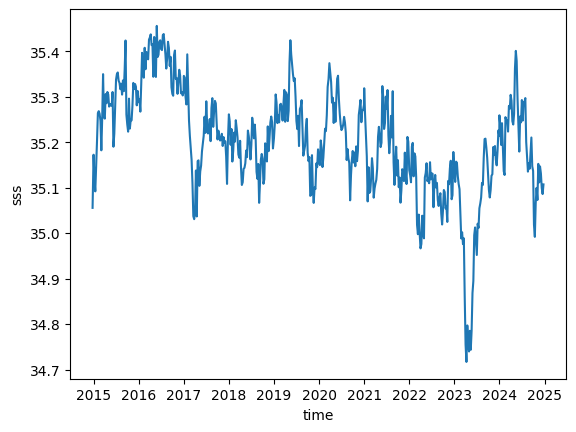

In [65]:
ds_semanal.sel(latitude=slice(-10, -5), longitude=slice(-80, -75))['sss'].mean(['latitude', 'longitude']).plot()

Creando mapas de salinidad media por mes...


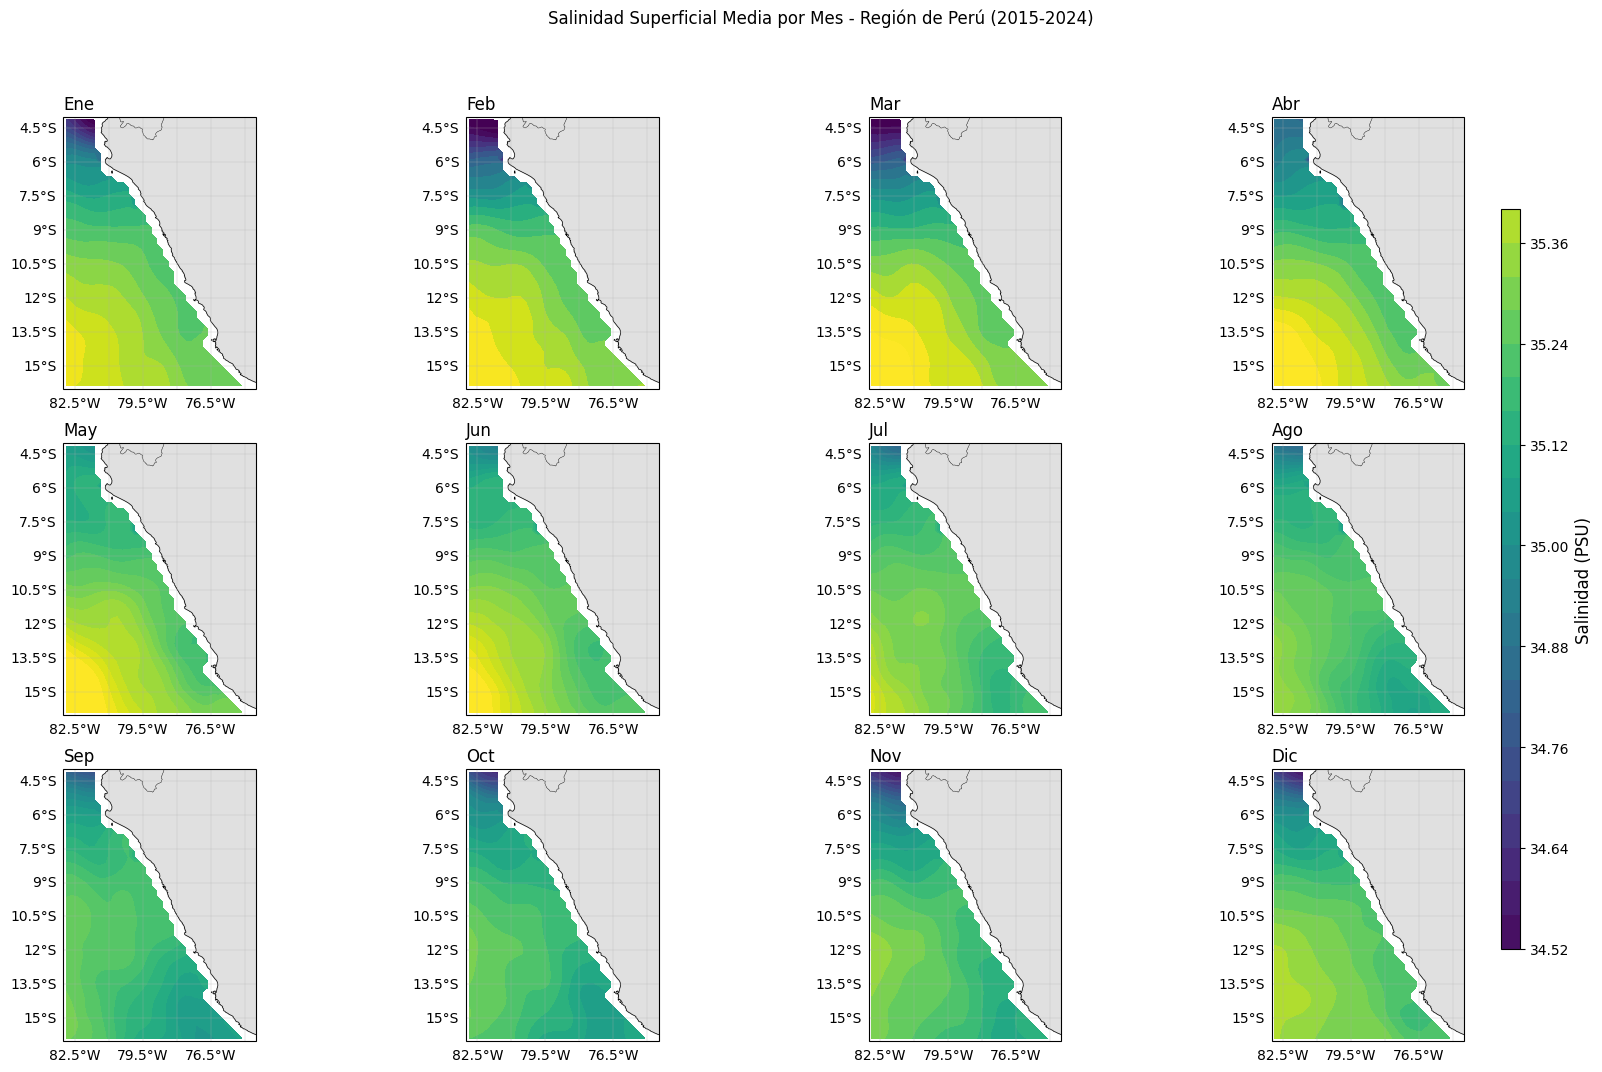

In [68]:
# Mapas de salinidad media por mes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def crear_mapas_salinidad_mensual(ds):
    """
    Crea mapas de salinidad media por mes
    """
    ds_monthly = ds.groupby('time.month').mean(dim='time')
    
    fig, axes = plt.subplots(3, 4, figsize=(24, 12), 
                           subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
              'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    
    vmin = 34.5
    vmax = 35.5
    
    for i, month in enumerate(range(1, 13)):
        ax = axes[i]
        
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.7)
        
        if month in ds_monthly.month:
            sss_month = ds_monthly.sel(month=month).sss
            im = ax.contourf(sss_month.longitude, sss_month.latitude, sss_month,
                           levels=21, cmap='viridis', vmin=vmin, vmax=vmax,
                           transform=ccrs.PlateCarree())
        
        ax.set_xlim(-83, -74.5)
        ax.set_ylim(-16, -4)
        ax.set_title(f'{months[i]}', fontsize=12, loc='left')
        
        gl = ax.gridlines(linewidth=0.3, alpha=0.7)
        gl.bottom_labels = True  
        gl.left_labels = True    
        gl.top_labels = False
        gl.right_labels = False
    
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', 
                       pad=0.02, shrink=0.8, aspect=40)
    cbar.set_label('Salinidad (PSU)', fontsize=12)
    
    fig.suptitle('Salinidad Superficial Media por Mes - Región de Perú (2015-2024)', 
                fontsize=12, y=0.97)
    
    plt.show()
    
    return ds_monthly

print("Creando mapas de salinidad media por mes...")
ds_monthly = crear_mapas_salinidad_mensual(ds_semanal)

PermissionError: [Errno 13] Permission denied: '/home/jupyter-daniela/suyana/peru_production/features/OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc'

In [ ]:

print("Calculando anomalías de SSS...")
ds_anomalias = calcular_anomalias_sss(ds_semanal)

print(f"Dataset de anomalías:")
print(f"Dimensiones: {ds_anomalias.dims}")
print(f"Rango de anomalías SSS: {ds_anomalias.sss.min().values:.3f} a {ds_anomalias.sss.max().values:.3f}")

ds_anomalias.to_netcdf(features_path / "OISSS_sss_anomalies_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")
print("Anomalías guardadas exitosamente")

Calculando anomalías de SSS...
Dataset de anomalías:
Dimensiones: FrozenMappingWarningOnValuesAccess({'longitude': 34, 'latitude': 48, 'time': 524})
Rango de anomalías SSS: -1.216 a 0.895
Anomalías guardadas exitosamente
Anomalías guardadas exitosamente


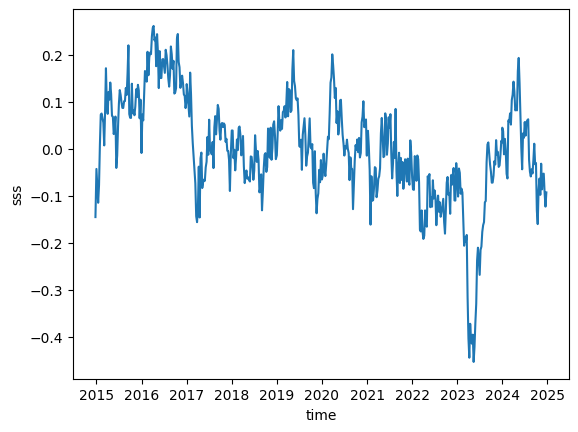

In [ ]:
ds_anomalias.sel(latitude=slice(-10, -5), longitude=slice(-80, -75))['sss'].mean(['latitude', 'longitude']).plot()